# Proyecto Final - IA - Machine Learning
## Arquitectura 2: Convolutional Neural Network (CNN) para Clasificación de Enfermedades en Plantas

**Dataset:** Plant Disease Prediction (Kaggle)  
https://www.kaggle.com/datasets/dittakavinikhita/plant-disease-prediction-disease-and-healthy

Red convolucional (CNN) usando TensorFlow/Keras para clasificar imágenes de plantas en categorías de enfermedades y hojas sana.

## 1. Introducción y Objetivo

### Descripción del problema

**Clasificar imágenes de plantas** según su estado de salud:
hoja sana o con alguna enfermedad.

Se usará una **CNN**

### ¿Por qué este dataset?

- Es un dataset recomendado y con bastantes imagenes.
- Ya tiene la clasificacion lista.

### Imports e inicializacion

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)

# Configuración general
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
path = kagglehub.dataset_download("dittakavinikhita/plant-disease-prediction-disease-and-healthy")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plant-disease-prediction-disease-and-healthy' dataset.
Path to dataset files: /kaggle/input/plant-disease-prediction-disease-and-healthy


In [ ]:
DATA_DIR = os.path.join(path, "Dataset")
print("DATA_DIR:", DATA_DIR)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.3

DATA_DIR: /kaggle/input/plant-disease-prediction-disease-and-healthy/Dataset


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"  # <- explícito
)

temp_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Clases:", class_names)
print("Número de clases:", num_classes)

Found 892 files belonging to 2 classes.
Using 625 files for training.
Found 892 files belonging to 2 classes.
Using 267 files for validation.
Clases: ['Disease', 'Healthy']
Número de clases: 2


In [ ]:
temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches = temp_batches // 2  # mitad para validación

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

print("Batches train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Batches val:", tf.data.experimental.cardinality(val_ds).numpy())
print("Batches test:", tf.data.experimental.cardinality(test_ds).numpy())

Batches train: 20
Batches val: 4
Batches test: 5


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

### Ejemplos en el dataset

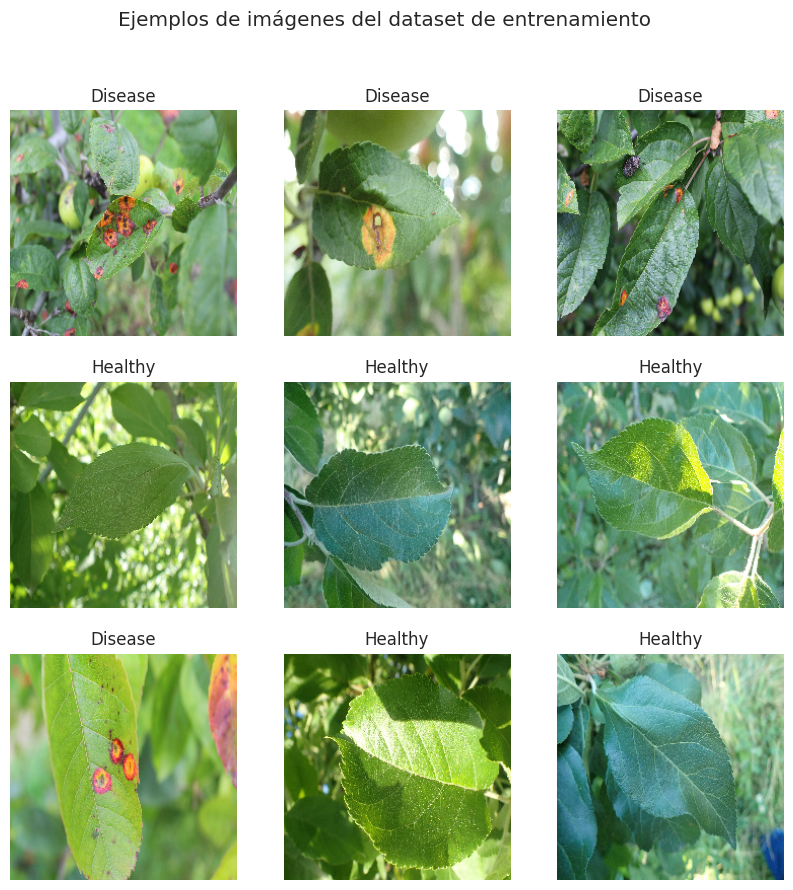

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Ejemplos de imágenes del dataset de entrenamiento")
plt.show()

### Distribucion de clases, data augmentation y normalizacion

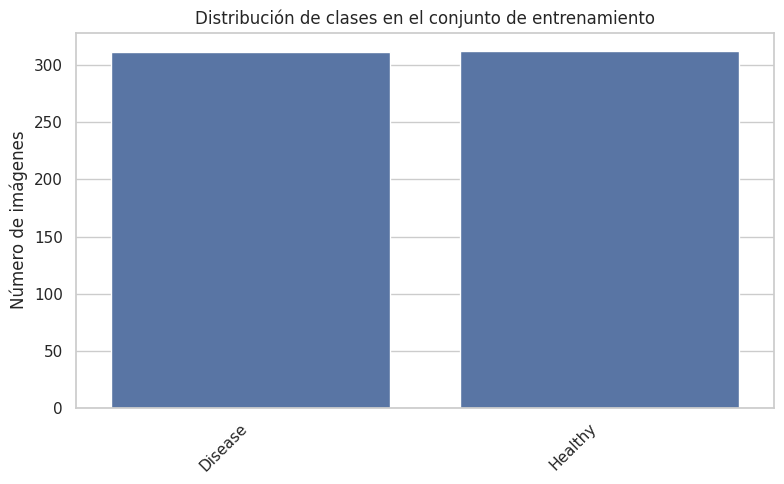

{'Disease': 312, 'Healthy': 313}

In [ ]:
label_counts = {name: 0 for name in class_names}

for _, labels in train_ds.unbatch():
    label_counts[class_names[labels.numpy()]] += 1

plt.figure()
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Número de imágenes")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.tight_layout()
plt.show()

label_counts

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)
normalization_layer = layers.Rescaling(1.0 / 255)

### CNN definition

In [ ]:
def build_cnn_model(input_shape=IMG_SIZE + (3,), num_classes=10):
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),

            data_augmentation,
            normalization_layer,

            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ],
        name="PlantDiseaseCNN"
    )
    return model

model = build_cnn_model(input_shape=IMG_SIZE + (3,), num_classes=num_classes)
model.summary()

Model: "PlantDiseaseCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,234,242 (50.48 MB)

 Trainable params: 13,234,242 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "PlantDiseaseCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,234,242 (50.48 MB)

 Trainable params: 13,234,242 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_path = "best_cnn_plant_disease.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True
    )
]

### Entrenamiento

In [ ]:
for images, labels in train_ds.take(1):
    print("images:", images.shape, images.dtype)
    print("labels:", labels.shape, labels.dtype)
    print("unique labels:", tf.unique(labels)[0])

images: (32, 224, 224, 3) <dtype: 'float32'>
labels: (32,) <dtype: 'int32'>
unique labels: tf.Tensor([0 1], shape=(2,), dtype=int32)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 414ms/step - accuracy: 0.5026 - loss: 0.9626 - val_accuracy: 0.5156 - val_loss: 0.6888
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - accuracy: 0.5497 - loss: 0.6895 - val_accuracy: 0.5234 - val_loss: 0.6774
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 336ms/step - accuracy: 0.5927 - loss: 0.6507 - val_accuracy: 0.7031 - val_loss: 0.5978
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 367ms/step - accuracy: 0.6623 - loss: 0.6190 - val_accuracy: 0.8750 - val_loss: 0.3401
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 361ms/step - accuracy: 0.8547 - loss: 0.3594 - val_accuracy: 0.9297 - val_loss: 0.2295
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 641ms/step - accuracy: 0.9384 - loss: 0.1685 - val_accuracy: 0.9609 - val_loss: 0.2171
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.9566 - loss: 0.1403 - val_accuracy: 0.9531 - val_loss: 0.2229
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.9821 - loss: 0.0705 - val_accu

### Curva de entrenamiento

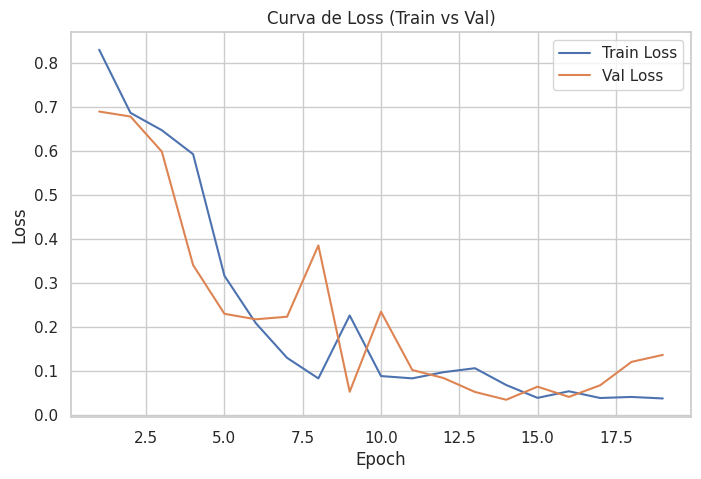

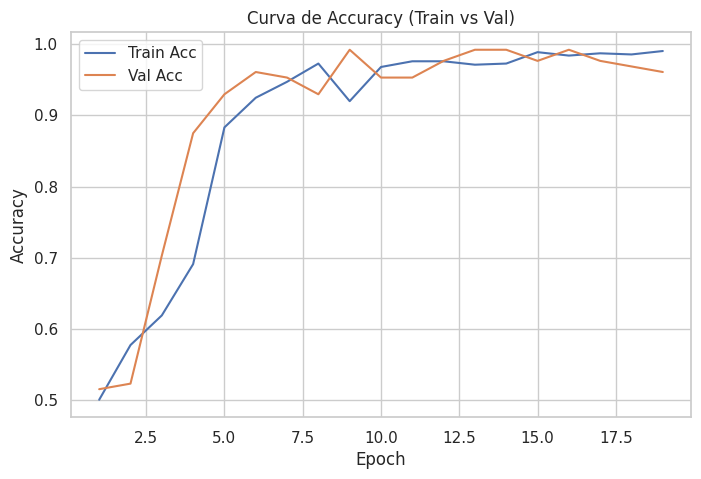

In [ ]:
history_dict = history.history
epochs_range = range(1, len(history_dict["loss"]) + 1)

plt.figure()
plt.plot(epochs_range, history_dict["loss"], label="Train Loss")
plt.plot(epochs_range, history_dict["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss (Train vs Val)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, history_dict["accuracy"], label="Train Acc")
plt.plot(epochs_range, history_dict["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy (Train vs Val)")
plt.legend()
plt.show()

### Resultados

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0900
Test Accuracy: 0.9712


### Predicciones

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print("Test Accuracy (sklearn):", acc)
print("Test Precision (weighted):", precision)
print("Test Recall (weighted):", recall)
print("Test F1-score (weighted):", f1)

print("\nClassification report (por clase):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Test Accuracy (sklearn): 0.9784172661870504
Test Precision (weighted): 0.9785367223033529
Test Recall (weighted): 0.9784172661870504
Test F1-score (weighted): 0.978426232374437

Classification report (por clase):
              precision    recall  f1-score   support

     Disease     0.9697    0.9846    0.9771        65
     Healthy     0.9863    0.9730    0.9796        74

    accuracy                         0.9784       139
   macro avg     0.9780    0.9788    0.9783       139
weighted avg     0.9785    0.9784    0.9784       139



### Matriz de confusion

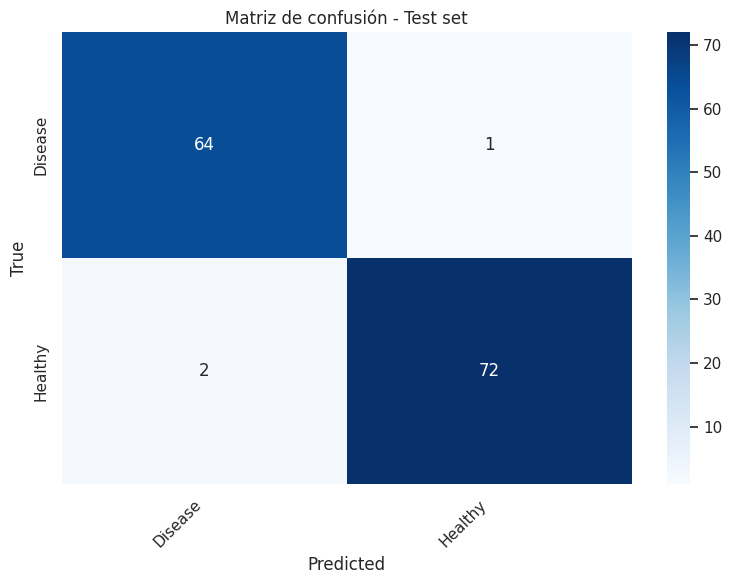

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión - Test set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Ejemplos de predicciones

Found 892 files belonging to 2 classes.
Using 267 files for validation.
=== Ejemplos de predicciones correctas ===


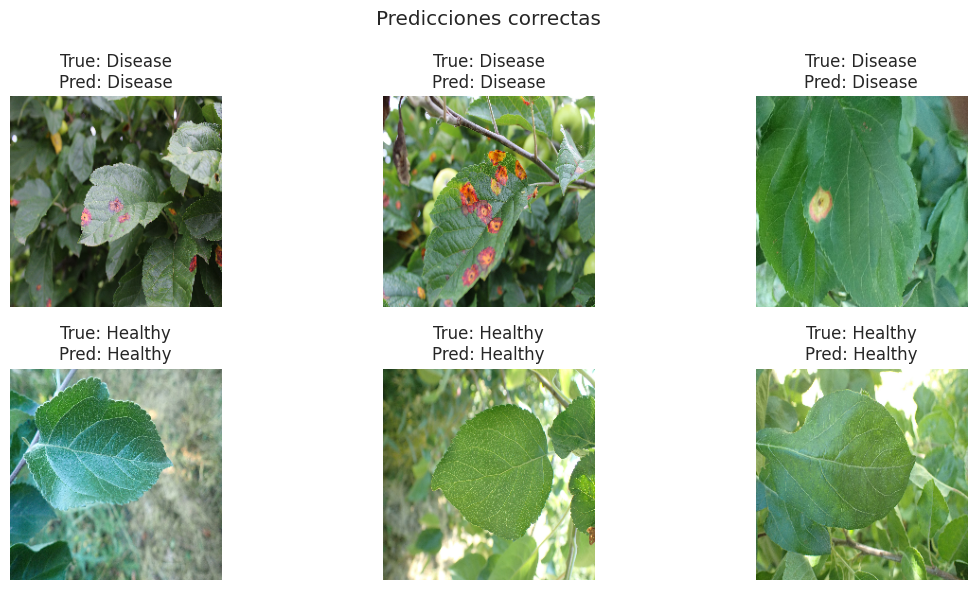

=== Ejemplos de predicciones incorrectas ===


<Figure size 1200x600 with 0 Axes>

In [ ]:
test_ds_no_prefetch = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_batches = tf.data.experimental.cardinality(test_ds_no_prefetch).numpy()
val_batches = temp_batches // 2
_ = test_ds_no_prefetch.take(val_batches)
test_ds_images = test_ds_no_prefetch.skip(val_batches)

images_list = []
labels_list = []
preds_list = []

for images, labels in test_ds_images.take(3):
    preds = model.predict(images, verbose=0)
    images_list.append(images.numpy())
    labels_list.append(labels.numpy())
    preds_list.append(np.argmax(preds, axis=1))

images_np = np.concatenate(images_list, axis=0)
labels_np = np.concatenate(labels_list, axis=0)
preds_np = np.concatenate(preds_list, axis=0)

correct_idx = np.where(labels_np == preds_np)[0]
wrong_idx   = np.where(labels_np != preds_np)[0]

def show_examples(indices, title, max_examples=6):
    plt.figure(figsize=(12, 6))
    n = min(max_examples, len(indices))
    for i in range(n):
        idx = indices[i]
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images_np[idx].astype("uint8"))
        true_label = class_names[labels_np[idx]]
        pred_label = class_names[preds_np[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("=== Ejemplos de predicciones correctas ===")
show_examples(correct_idx, "Predicciones correctas", max_examples=6)

print("=== Ejemplos de predicciones incorrectas ===")
show_examples(wrong_idx, "Predicciones incorrectas", max_examples=6)

## Resumen, analisis y conclusiones

La arquitectura de la CNN es:

- **Entrada:** imágenes RGB de tamaño 224 x 224 x 3.
- **Preprocesamiento en el modelo:**
  - `data_augmentation`: RandomFlip, RandomRotation, RandomZoom
  - `Rescaling(1/255)` para normalizar píxeles a [0, 1]

- **Bloque convolucional 1:**
  - Conv2D(32 filtros, kernel 3x3, padding='same', ReLU)
  - MaxPooling2D(2x2)

- **Bloque convolucional 2:**
  - Conv2D(64 filtros, kernel 3x3, ReLU)
  - MaxPooling2D(2x2)

- **Bloque convolucional 3:**
  - Conv2D(128 filtros, kernel 3x3, ReLU)
  - MaxPooling2D(2x2)

- **Bloque convolucional 4:**
  - Conv2D(256 filtros, kernel 3x3, ReLU)
  - MaxPooling2D(2x2)

- **Capa densa final:**
  - Flatten
  - Dropout(0.5)
  - Dense(256, ReLU)
  - Dropout(0.5)
  - Dense(num_classes, softmax)

**Función de pérdida:** `sparse_categorical_crossentropy`  
**Optimizador:** Adam
**Batch size:** 32  
**Épocas:** 20

### Interpretación de Resultados

- La precisión fue de: 0.9712
- La matriz de confusión muestra que el modelo diferencia bien entre clases pero puede confundir algunas enfermedades similares.

### Limitaciones del Modelo

- No se han hecho ajustes mas profundos a los hiperparámetros.
- El dataset puede tener variaciones.

### Posibles Mejoras

- Realizar una mejora a los hiperparámetros: número de capas, filtros,
  dropout, learning rate, batch size, etc.
- Mejorar el esquema de data augmentation (cambios de brillo, contraste, etc.).